## Imports

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Get data
- Get Gaia data by query
- Read .csv data from APT

In [2]:
#gaia query

job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,\
gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS\
(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',181.660,49.380,19))=1 AND \
(gaiadr2.gaia_source.phot_bp_mean_mag<=20)")  

Query finished.


In [45]:
#get resulting gaia datatable
r = job.get_results() 
df_gaia = r.to_pandas()

In [46]:
#read apt datatable
filename = "phaseone_apt.csv"
df_apt = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]
#df_gaia = pd.read_csv("gaia.csv") #when gaia query doesnt work

In [47]:
df_gaia = df_gaia.query('dec<55').query('dec>40').query('ra>170').query('ra<195').dropna().reset_index(drop=True)
df_apt = df_apt.query('CentroidDec<55').query('CentroidDec>40').\
query('CentroidRA>170').query('CentroidRA<195').dropna().reset_index(drop=True)

## Functions

In [48]:
def p_scatter(df1, df2, x, y, xlim =[0,0] , ylim=[0,0]):
    '''
    This function uses matplotlib.pyplot to graph two functions and fix axis (calculated if not given).
    df2 should be the smaller subset.
    '''
    axes = plt.gca()
    plt.scatter(df1[x], df1[y]) 
    plt.scatter(df2[x], df2[y]) 
    if xlim == [0,0]:
        xlim = [df[x].min()-(df[x].max()-df[x].min())*0.05, df[x].max() + (df[x].max()-df[x].min())*0.05]
    if ylim == [0,0]:
        ylim = [df[y].min()-(df[y].max()-df[y].min())*0.05, df[y].max() + (df[y].max()-df[y].min())*0.05]
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    plt.xlabel(x)
    plt.ylabel(y)

## Match data

Text(0.5,1,'Position match')

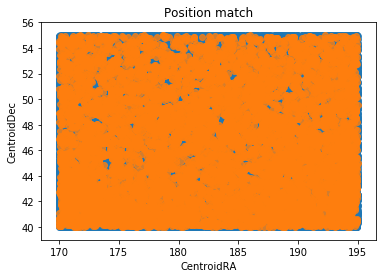

In [49]:
#Check ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

In [ ]:
#match
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','pmra','pmdec',\
                           'CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) 
min_dist = np.argmin(dist, axis=1) 

m = 0
while m < len(df_apt): 
    n = min_dist[m]   
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'pmra': df_gaia['pmra'][n], 'pmdec': df_gaia['pmdec'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n]
                   }, ignore_index=True)
    if m == int(round(len(df_apt)/10)):
        print(u"\u2588")
    m+=1
    
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [ ]:
#delete duplicates
maxdiff = 0.05
querystr = "diff<" + str(maxdiff)
df = df.query(querystr)
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')

In [70]:
print('Gaia:', len(df_gaia), '\nAPT:', len(df_apt), '\nMatched:', len(df), '('+ \
      str(round(len(df)/len(df_apt)*100,2))+"% of all APT results)")

Gaia: 280732 
APT: 9006 
Matched: 7532 (83.63% of all APT results)


### Regression for magnitude

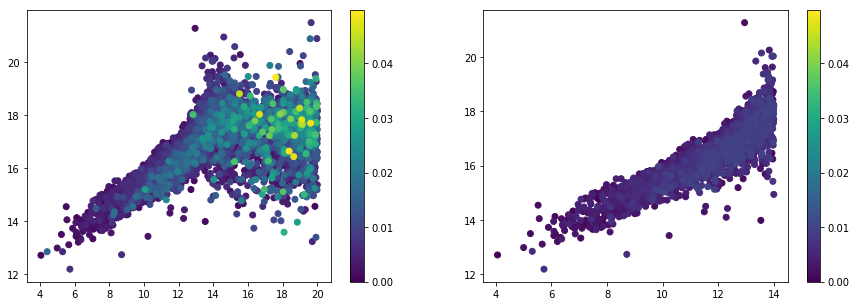

In [87]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
plt.scatter(df['phot_bp_mean_mag'], df['Magnitude'], c = df['diff']) 
plt.clim(0,df['diff'].max())
plt.colorbar()

ax1 = fig.add_subplot(122)
df_ = df.query('phot_bp_mean_mag<14').query('diff<0.01')
plt.scatter(df_['phot_bp_mean_mag'], df_['Magnitude'], c = df_['diff']) 
plt.clim(0,df['diff'].max())
plt.colorbar()

In [89]:
X = df_["phot_bp_mean_mag"] 
y = df_["Magnitude"]
X = sm.add_constant(X) #intercept 

model = sm.OLS(y, X).fit() 
model.summary()
print(model.params)

const               9.674746
phot_bp_mean_mag    0.577371
dtype: float64


In [ ]:
df['mag_mod'] =  model.params['phot_bp_mean_mag']*df_gaia.phot_bp_mean_mag + model.params['const']
df['diff_mag'] = df['mag_mod'] - df['Magnitude']

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


KeyError: 'diff_mag'

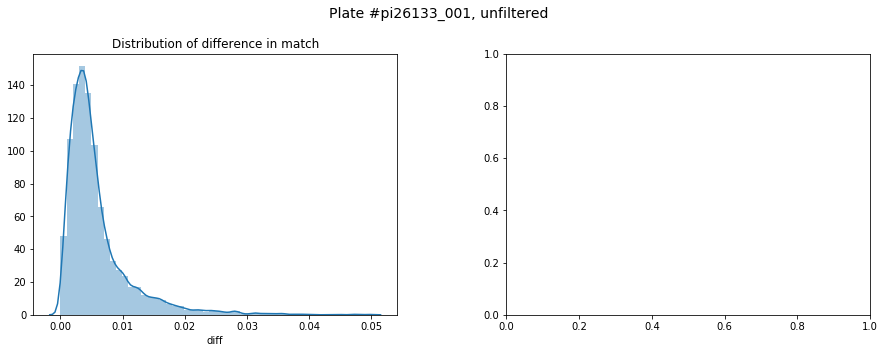

In [90]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(122)
sns.distplot(df['diff_mag']).set_title('Distribution of difference in match')

In [20]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.02')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

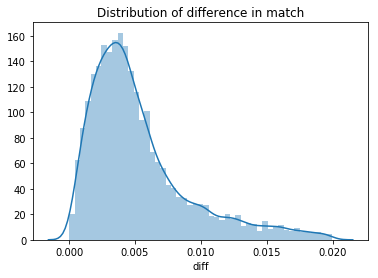

In [21]:
sns.distplot(df_filtered['diff']).set_title('Distribution of difference in match')

In [ ]:
sns.distplot(df_filtered['diff']).set_title('Distribution of difference in match')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


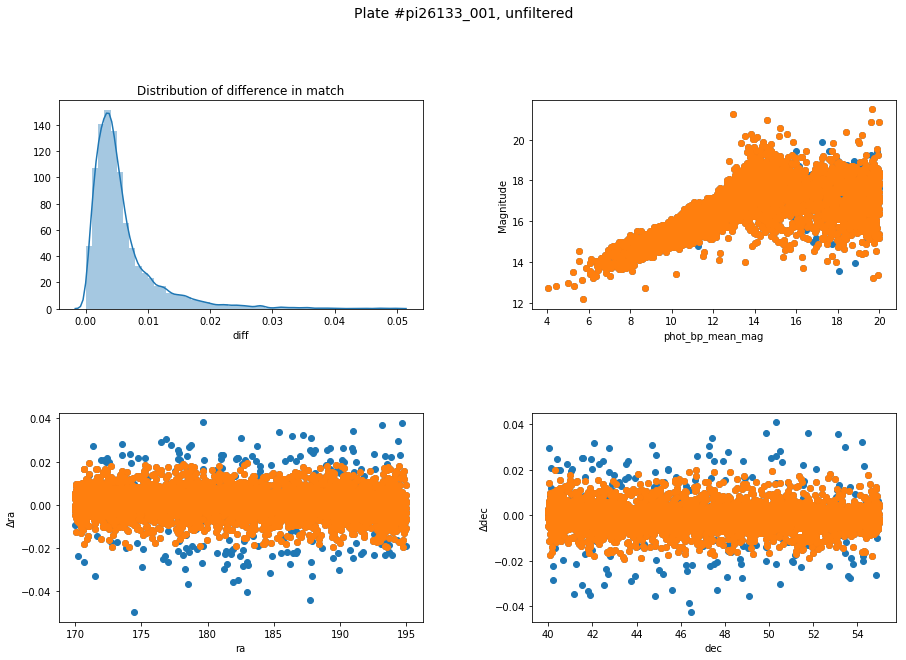

In [22]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001, unfiltered", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
p_scatter(df, df_filtered, 'phot_bp_mean_mag', 'Magnitude')
ax3 = fig.add_subplot(2,2,3)
#sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
p_scatter(df, df_filtered, 'ra', 'Δra')
ax4 = fig.add_subplot(2,2,4)
p_scatter(df, df_filtered, 'dec', 'Δdec')

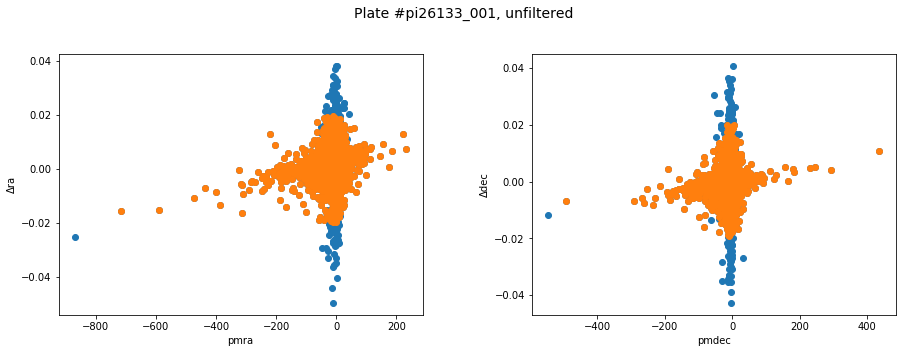

In [24]:
fig = plt.figure(figsize=(15,5))
title = fig.suptitle("Plate #pi26133_001, unfiltered", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(1,2,1)
p_scatter(df, df_filtered, 'pmra', 'Δra')
ax2 = fig.add_subplot(1,2,2)
p_scatter(df, df_filtered, 'pmdec', 'Δdec')

Text(0,0.5,'Δdec')

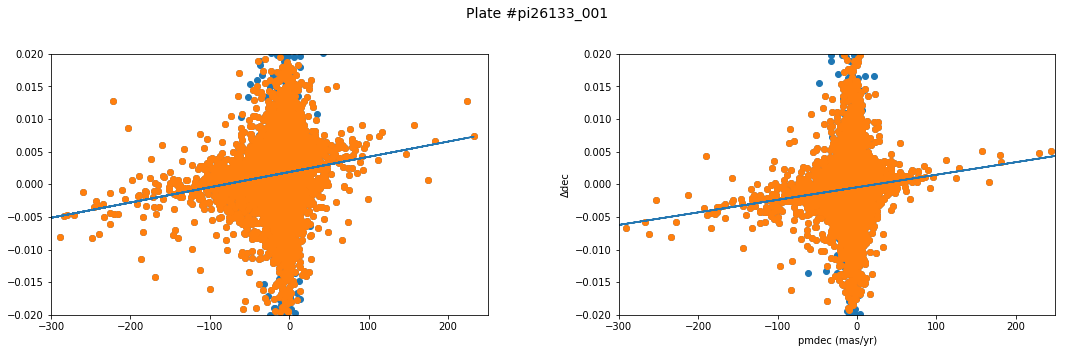

In [25]:
#graphing proper motion

df_na = df.dropna().reset_index(drop=True)#for regression
fig = plt.figure(figsize=(18,5))#graph size
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(121)#graph1
X = df_na["pmra"] #regression model
y = df_na["Δra"] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() 
pred = df_na["pmra"]*model.params['pmra']+model.params['const']
plt.scatter(df["pmra"], df["Δra"]) #points = 
plt.scatter(df_filtered["pmra"], df_filtered["Δra"])
plt.plot(df_na["pmra"],pred,'#2678b2')#regression
axes = plt.gca()#axis names
axes.set_xlim([-300,250])
axes.set_ylim([-0.02,0.02])


ax1 = fig.add_subplot(122)#graph2
X = df_na["pmdec"] #regression model
y = df_na["Δdec"] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() 
pred = df_na["pmdec"]*model.params['pmdec']+model.params['const']
plt.scatter(df["pmdec"], df["Δdec"]) #points = 
plt.scatter(df_filtered["pmdec"], df_filtered["Δdec"])
plt.plot(df_na["pmdec"],pred,'#2678b2')#regression
axes = plt.gca()
axes.set_xlim([-300,250])
axes.set_ylim([-0.02,0.02])
plt.xlabel("pmdec (mas/yr)")
plt.ylabel("Δdec")

- Then create new colomn mag_diff
df_gaia['mag_mod'] = 0.5338*df_gaia.phot_bp_mean_mag+10.1265

- Graph including difference in mag

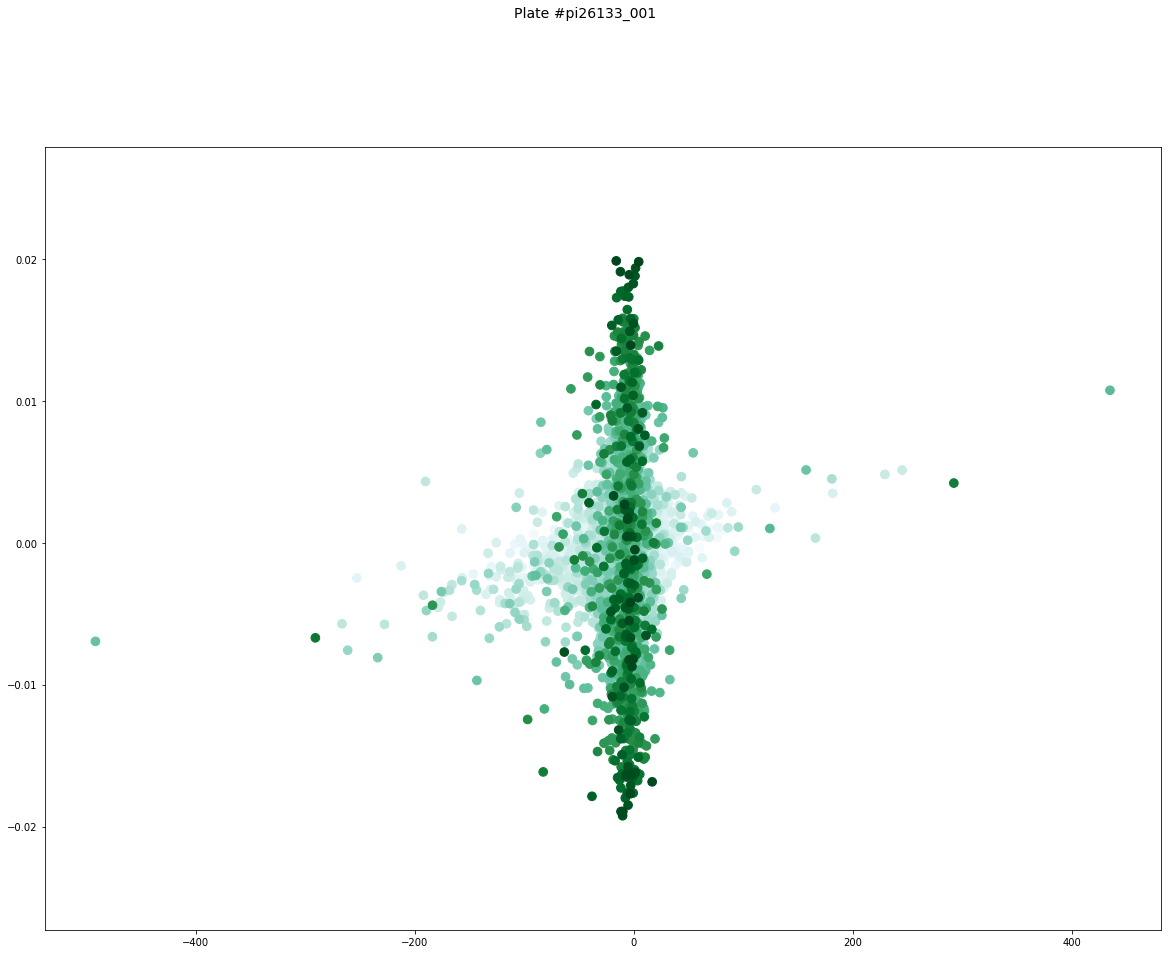

In [26]:
df_na = df.dropna().reset_index(drop=True)#for regression
fig = plt.figure(figsize=(20,15))#graph size
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

points = plt.scatter(df_filtered["pmdec"], df_filtered["Δdec"],
                     c=df_filtered["diff"], s=75, cmap="BuGn")
axes = plt.gca()
#axes.set_ylim([-0.012, 0.012])
#sns.regplot('pmra','Δra',c = 'diff_mag',data=df_filtered).set_title('pmra')

Text(0.5,1,'pmdec')

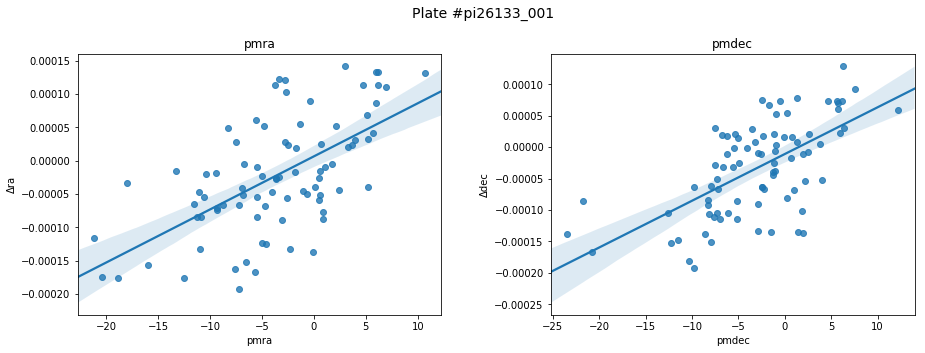

In [39]:
fig = plt.figure(figsize=(15,5))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('pmra','Δra',data=df_filtered).set_title('pmra')
ax2 = fig.add_subplot(1,2,2)
sns.regplot('pmdec','Δdec',data=df_filtered).set_title('pmdec')